# Set-up

## Installing libraries and libcudnn8

In [1]:
import os

FILEID = "1h4FWB5fw7sBDCSM-EENK1UadqKSCqg24"

contents = os.listdir(os.getcwd())

if 'MI_EEG_ClassMeth' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
    !unzip MI_EEG_ClassMeth.zip
else:
    print("MI_EEG_ClassMeth already downloaded!")

!apt-get install --allow-change-held-packages libcudnn8=8.1.1.33-1+cuda11.2 -y
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases
!pip install mne
!pip install pickle5
!pip install gcpds.utils
!pip install scikeras[tensorflow]

--2024-10-31 02:03:14--  https://docs.google.com/uc?export=download&confirm=&id=1h4FWB5fw7sBDCSM-EENK1UadqKSCqg24
Resolving docs.google.com (docs.google.com)... 74.125.132.139, 74.125.132.138, 74.125.132.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.132.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1h4FWB5fw7sBDCSM-EENK1UadqKSCqg24&export=download [following]
--2024-10-31 02:03:14--  https://drive.usercontent.google.com/download?id=1h4FWB5fw7sBDCSM-EENK1UadqKSCqg24&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.184.132, 2607:f8b0:4001:c66::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.184.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86900 (85K) [application/octet-stream]
Saving to: ‘MI_EEG_ClassMeth.zip’

MI_EEG_ClassMeth.zi 100%[===================>]  84.86K 

## Import libraries

In [2]:
# freq filter 
from MI_EEG_ClassMeth.FeatExtraction import TimeFrequencyRpr

#EEG montage
from gcpds.utils.mne_handler import get_best_montage

# general
import numpy as np
from scipy.signal import resample
import pickle5 as pickle
import warnings
import mne
from time import time
warnings.filterwarnings('ignore')

# tensorlfow 
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, AveragePooling2D, BatchNormalization, Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import L1L2

# scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score

In [3]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git

from gcpds.visualizations.topoplots import topoplot

  Cloning https://github.com/UN-GCPDS/python-gcpds.visualizations.git to /tmp/pip-req-build-ulkpyxpf
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.visualizations.git /tmp/pip-req-build-ulkpyxpf
  Resolved https://github.com/UN-GCPDS/python-gcpds.visualizations.git to commit 162dbeac141a7472d3b0bd7f005932241b4663a5
  Preparing metadata (setup.py) ... done
  Created wheel for gcpds-visualizations: filename=gcpds_visualizations-0.6-py3-none-any.whl size=12467 sha256=fb01756d7f9fe16dcc4f377cdd061c1d1aaf9acfc4245548217df4dbf9518fd0
  Stored in directory: /tmp/pip-ephem-wheel-cache-5jf_ca1o/wheels/5c/2b/15/2aa61b5c7a2acfaacca74b52bb24a5265f93c1019ada427d3a
Successfully built gcpds-visualizations


## Define functions

In [4]:
def kappa(y_true, y_pred):
    return cohen_kappa_score(np.argmax(y_true, axis = 1),np.argmax(y_pred, axis = 1))

## PAIN dataset

In [5]:
def load_PAIN(db,sbj,f_bank,vwt,new_fs):

    channels_names = np.array(['Fp1','Fp2',
                      'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8',
                      'T7','T8','P7','P8','Fz','Cz','Pz','Oz',
                      'FC1','FC2','CP1','CP2','FC5','FC6','CP5','CP6',
                      'TP9','TP10','LE','RE','P1','P2','C1','C2',
                      'FT9','FT10','AF3','AF4','FC3','FC4','CP3','CP4','PO3','PO4',
                      'F5','F6','C5','C6','P5','P6','PO9','Iz','FT7','FT8',
                      'TP7','TP8','PO7','PO8','Fpz','PO10','CPz','POz',
                      'Ne','Ma','Ext','ECG'])
    
    with open('{}BMOP_Motor_S{}.pkl'.format(db,'0' + str(sbj) if sbj < 10 else sbj), 'rb') as f:
        data = pickle.load(f)
        
    X = data['X']  # trials, channels, time
    y = data['y']
    sex = data['sex'].ravel()
    age = data['age'].ravel()
    fs = float(data['fs'])
    
    tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)
    
    #Read electrode positions to load the best standard montage-MNE
    best_montages = get_best_montage(channels_names)
    montage = best_montages.iloc[0]['montage']
    no_channels = np.array(best_montages.iloc[0]['missings channels'])
    channels_to_remove = np.array([np.argwhere(channels_names==no)[0] for no in no_channels])[:,0]

    #Delete the missing channels the original array respecting the positions
    channels_names = np.delete(channels_names, channels_to_remove)
    X = np.delete(X, channels_to_remove, axis=1)

    #Number channels does not match with the dimension of X, 
    #thus the last channel is discarded because it has weird amplitudes
    X = X[:,:-1,:]

    info = mne.create_info(list(channels_names), sfreq=fs, ch_types="eeg")
    info.set_montage(montage)
    info

    event_id = {
        'pain/high':2,
        'resting':3,
        }

    events = [[i, 1, cls[0]] for i, cls in enumerate(y)]
    tmin = 0

    epochs = mne.EpochsArray(X, info, events=events, tmin=tmin, event_id=event_id)
    X = epochs.get_data()
    y = y-2
    X = np.squeeze(tf_repr.transform(X))
                             
    if new_fs != fs:
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)
    return X,y,age,sex,fs

## Define the models

### KSC-GFCNet

In [6]:
class GFC(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.gammad = self.add_weight(name = 'gammad',
                                shape = (),
                                initializer = 'zeros',
                                trainable = True)
        super().build(batch_input_shape)

    def call(self, X): 
        X = tf.transpose(X, perm  = (0, 3, 1, 2)) #(N, F, C, T)
        R = tf.reduce_sum(tf.math.multiply(X, X), axis = -1, keepdims = True) #(N, F, C, 1)
        D  = R - 2*tf.matmul(X, X, transpose_b = True) + tf.transpose(R, perm = (0, 1, 3, 2)) #(N, F, C, C)

        ones = tf.ones_like(D[0,0,...]) #(C, C)
        mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
        mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
        triu = tf.expand_dims(tf.boolean_mask(D, mask, axis = 2), axis = -1) #(N, F, C*(C-1)/2, 1)
        sigma = tfp.stats.percentile(tf.math.sqrt(triu), 50, axis = 2, keepdims = True) #(N, F, 1, 1)

        A = tf.math.exp(-1/(2*tf.pow(10., self.gammad)*tf.math.square(sigma))*D) #(N, F, C, C)
        A.set_shape(D.shape)
        return A

    def compute_output_shape(self, batch_input_shape):
        N, C, T, F = batch_input_shape.as_list()
        return tf.TensorShape([N, F, C, C])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}


class get_triu(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        super().build(batch_input_shape)

    def call(self, X): 
        N, F, C, C = X.shape
        ones = tf.ones_like(X[0,0,...]) #(C, C)
        mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
        mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
        triu = tf.expand_dims(tf.boolean_mask(X, mask, axis = 2), axis = -1) #(N, F, C*(C-1)/2, 1)

        triu.set_shape([N,F,int(C*(C-1)/2),1])
        return triu

    def compute_output_shape(self, batch_input_shape):
        N, F, C, C = batch_input_shape.as_list()
        return tf.TensorShape([N, F, int(C*(C-1)/2),1])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}
    
    
def GFC_triu_net_avg(nb_classes: int,
          Chans: int,
          Samples: int,
          l1: int = 0, 
          l2: int = 0, 
          dropoutRate: float = 0.5,
          filters: int = 1, 
          maxnorm: float = 2.0,
          maxnorm_last_layer: float = 0.5,
          kernel_time_1: int = 20,
          strid_filter_time_1: int = 1,
          bias_spatial: bool = False) -> Model:


    input_main   = Input((Chans, Samples, 1),name='Input')                    
    
    block        = Conv2D(filters,(1,kernel_time_1),strides=(1,strid_filter_time_1),
                            use_bias=bias_spatial, name='conv2d',
                            kernel_constraint = max_norm(maxnorm, axis=(0,1,2))
                            )(input_main)
    
    block        = BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = Activation('elu')(block)      
    
    block        = GFC(name='gfc')(block)

    block        = get_triu()(block)

    block        = AveragePooling2D(pool_size=(block.shape[1],1),strides=(1,1))(block)
    
    block        = BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = Activation('elu')(block) 
    
    block        = Flatten(name='fc')(block)    

    block        = Dropout(dropoutRate)(block) 

    block        = Dense(nb_classes, kernel_regularizer=L1L2(l1=l1,l2=l2),name='logits',
                              kernel_constraint = max_norm(maxnorm_last_layer)
                              )(block)

    softmax      = Activation('softmax',name='output')(block)
    
    return Model(inputs=input_main, outputs=softmax)

### EEGNet

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))

    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   name='Conv2D_1',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   name='Depth_wise_Conv2D_1',
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   name='Separable_Conv2D_1',
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'output',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'out_activation')(dense)

    return Model(inputs=input1, outputs=softmax)

## Load Scores and Get Adjacency Matrixes Functions

In [8]:
from scipy.stats import ks_2samp
from scipy.spatial.distance import squareform,cdist
from scipy.signal import resample

def ks_connetivity_cal(A,y):
    D=A.shape[-1]
    ks = np.zeros(D)
    pvalue = np.zeros(D)
    for d in range(D):
        ks[d],pvalue[d]=ks_2samp(A[y==0, d], A[y==1, d], alternative = 'two-side', mode = 'auto')
    return ks, pvalue

def renyis_entropy_2(A):
    """
    Renyis entropy with alpha = 2
    Input
    -----
    A Tensor (batch_dim, n_freq_bands, n_chans, n_chans)
    Output
    ------
    H Tensor (batch_dim, n_freq_bands)
    """
    A = A/tf.reshape(tf.linalg.trace(A),(-1,1,1))
    H = -1*tf.math.log(tf.linalg.trace(tf.linalg.matmul(A ,A)))
    return H

## Download Weigths and Scores

### KCS-GFCNet

In [9]:
FILEID = "12bxViJ8j3U4RLWVbZa0SuRLcxojIdJvZ"

contents = os.listdir(os.getcwd())

if 'GFC_Motor_256_Gamma60Hz' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O GFC_Motor_256_Gamma60Hz.zip && rm -rf /tmp/cookies.txt
    !unzip GFC_Motor_256_Gamma60Hz.zip
else:
    print("GFC training info already downloaded!")

--2024-10-31 02:11:25--  https://docs.google.com/uc?export=download&confirm=&id=12bxViJ8j3U4RLWVbZa0SuRLcxojIdJvZ
Resolving docs.google.com (docs.google.com)... 74.125.132.139, 74.125.132.113, 74.125.132.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.132.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=12bxViJ8j3U4RLWVbZa0SuRLcxojIdJvZ&export=download [following]
--2024-10-31 02:11:25--  https://drive.usercontent.google.com/download?id=12bxViJ8j3U4RLWVbZa0SuRLcxojIdJvZ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.184.132, 2607:f8b0:4001:c66::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.184.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 894052 (873K) [application/octet-stream]
Saving to: ‘GFC_Motor_256_Gamma60Hz.zip’

GFC_Motor_256_Gamma 100%[===================>]

### EEGNet

In [12]:
import shutil
FILEID = "1PfhH5Uj5oKK2AY3Mgltw1iD42smIiO9d"

contents = os.listdir(os.getcwd())

folder = 'MotorConditionEEGNet_60Hz'

if 'MotorConditionEEGNet_60Hz' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MotorConditionEEGNet_60Hz.zip && rm -rf /tmp/cookies.txt
    !unzip MotorConditionEEGNet_60Hz.zip
    os.makedirs(folder)

    for content in contents:
        if '.p' in content or '.h5' in content:
            shutil.move(os.path.join(os.getcwd(), content), os.path.join(os.getcwd(), folder, content))
else:
    print("GFC training info already downloaded!")

## Load Results

In [13]:
import os

db = '../input/brain-mediators-of-pain-motor/'

num_class = 2

load_args = dict(db = db,
            f_bank = np.asarray([[4., 60.]]),
            vwt = np.asarray([[0.5,2.5]]),
            new_fs = 256.0)

n_subjects = 51

subjects = np.arange(n_subjects)+1
subjects = np.delete(subjects, 17)

S = len(subjects)
C = 62

my_GFC_scores = np.zeros((S,6))
kernel_time_ = np.zeros((S))
Nfilters_ = np.zeros((S))
gammad_ = np.zeros((S))
alpha_ = np.zeros((S))

ks_ = np.zeros((subjects.shape[0], int(C*(C-1)/2)))
pvalue_ = np.zeros((subjects.shape[0], int(C*(C-1)/2)))
renyi_entropy_ks_ = np.zeros((subjects.shape[0],1))
renyi_entropy__adj_ks_ = dict()
renyi_entropy_adj_reg = dict()
sigma__reg =dict()
silverman__reg =dict()

A_sbjs_reg = np.zeros((subjects.shape[0], int(C*(C-1)/2)))
A_sbjs_max_reg  = np.zeros((subjects.shape[0], int(C*(C-1)/2)))
A_sbjs_median_reg  = np.zeros((subjects.shape[0], int(C*(C-1)/2)))

A_sbjs_mask_reg = np.zeros((subjects.shape[0], int(C*(C-1)/2)))
A_sbjs_max_mask_reg  = np.zeros((subjects.shape[0], int(C*(C-1)/2)))
A_sbjs_median_mask_reg  = np.zeros((subjects.shape[0], int(C*(C-1)/2)))

AA_full_reg=dict()
AA_reg=dict()

print(f'Loading info subjects',end=': ')

db_path = '../input/brain-mediators-of-pain-motor'
model_name = 'GFC'
folder = 'GFC_Motor_256_Gamma60Hz'

label = 0 # valence

logit_layer_reg={}
filter_layer_reg={}
for idx, sbj in enumerate(subjects):
    print(f'--{sbj}',end=' ')
    load_args['sbj'] = sbj
    
    X_train, y_train, age, sex, fs = load_PAIN(**load_args)

    X_train = X_train[..., np.newaxis]
    Y_train = tf.keras.utils.to_categorical(y_train,num_classes=num_class)

      #####
    model_weights_path = os.path.join(os.getcwd(), folder, f'Subject{sbj}_weights.h5')


    scores_path = os.path.join(os.getcwd(), folder, f'Subject{sbj}.p')
    
    #load scores
    with open(scores_path, 'rb') as f:
        cv = pickle.load(f)

    my_GFC_scores[idx] = cv['mean_test_Accuracy'][cv['best_index_']],cv['std_test_Accuracy'][cv['best_index_']],cv['mean_test_Kappa'][cv['best_index_']],cv['std_test_Kappa'][cv['best_index_']],cv['mean_test_AUC'][cv['best_index_']],cv['std_test_AUC'][cv['best_index_']]
    Nfilters_[idx] = cv['params'][cv['best_index_']]['filters']
    kernel_time_[idx] = cv['params'][cv['best_index_']]['kernel_time_1']

    print(f'scores loaded -- loading weights',end=' ')

    model = GFC_triu_net_avg(nb_classes = 2,
            Chans = X_train.shape[1],
            Samples = X_train.shape[2],
            filters = int(Nfilters_[idx]),
            kernel_time_1 =int(kernel_time_[idx]))

    model.load_weights(model_weights_path)
    
    print('weights loaded', end=' ')

    ### Get gfc layer (Adjancecy matrices)

    gfc_layer = model.get_layer(f'gfc')


    ### get gamma of the GFC net
    gammad_[idx] =gfc_layer.get_weights()[0]


    ###
    logit_layer_reg[idx] = model.get_layer('logits').get_weights()

    filter_layer_reg[idx] = model.get_layer('conv2d').get_weights()

    ### get GFC layer output

    layer_name=f'gfc'

    FC_layer = Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
    print('Getting adjancecy matrices',end=' ')
    A_full_reg = FC_layer.predict(X_train)
    AA_full_reg[sbj]=A_full_reg[0]
    sigma__reg[sbj]=A_full_reg[1]
    silverman__reg[sbj]=A_full_reg[2]


    ## get flatten layer output

    layer_name=f'fc'

    FC_layer = Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
    A_reg = FC_layer.predict(X_train)
    AA_reg[sbj]=A_reg
    print('calculating test over adjancecy matrices',end=' ')
    ### Kolmogorov-Smirnov
    ks_[idx],pvalue_[idx] = ks_connetivity_cal(A_reg, y_train.reshape(-1))


    # entropy kolmogorov matrix one per sbj
    renyi_entropy_ks_[idx] = renyis_entropy_2(squareform(ks_[idx])+np.eye(C))
    # entropy kolmogorov matrix hadammar GFC one per trial
    renyi_entropy__adj_ks_[idx] = [renyis_entropy_2(squareform(ks_[idx])*squareform(trial)+np.eye(C)) for trial in A_reg]
    # Initial entropy GFC one per trial
    renyi_entropy_adj_reg[idx] = [renyis_entropy_2(squareform(trial)+np.eye(C)) for trial in A_reg]

    ##
    A_sbjs_reg[idx] = np.mean(A_reg,axis=0)#
    A_sbjs_max_reg[idx] = np.max(A_reg,axis=0)
    A_sbjs_median_reg[idx] = np.median(A_reg,axis=0)
    ## pvalue masking A
    A_mask_reg = np.copy(A_reg)
    A_mask_reg[:,pvalue_[idx]>0.05]=0
    A_sbjs_mask_reg[idx] = np.mean(A_mask_reg,axis=0)#
    A_sbjs_max_mask_reg[idx] = np.max(A_mask_reg,axis=0)
    A_sbjs_median_mask_reg[idx] = np.median(A_mask_reg,axis=0)
    print('Done')

Loading info subjects: --1 Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [==============================] - 0s 35ms/step
calculating test over adjancecy matrices Done
--2 Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [==============================] - 0s 33ms/step
calculating test over adjancecy matrices Done
--3 Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [==============================] - 0s 22ms/step
calculating test over adjancecy matrices Done
--4 Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [==============================] - 0s 25ms/step
calculating test over adjancecy matrices Done
--5 Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
2/2 [==============================

In [14]:
#### initializating variables

S = len(subjects)
C = 64

print(f'Loading info subjects',end=': ')

load_args = {}

load_args = dict(db = './',
            f_bank = np.asarray([[4., 40.]]),
            vwt = np.asarray([[0.5,2.5]]),
            new_fs = 500.0)

db_path = '../input/brain-mediators-of-pain-motor'
model_name = 'EEGNet'
folder_name = 'MotorConditionEEGNet_60Hz'

label = 0 # valence


raw_eegnet = np.zeros((S,6))
# get EEGnet scores

print(f'Loading subjects info',end=': ')
for idx, sbj in enumerate(subjects):
    print(f'--{sbj}',end='')

    scores_full_path = os.path.join(os.getcwd(), folder_name, f'Subject{sbj}.p')

    with open(scores_full_path, 'rb') as f:
        cv = pickle.load(f)
    raw_eegnet[idx] = cv['mean_test_Accuracy'][cv['best_index_']],cv['std_test_Accuracy'][cv['best_index_']],cv['mean_test_Kappa'][cv['best_index_']],cv['std_test_Kappa'][cv['best_index_']],cv['mean_test_AUC'][cv['best_index_']],cv['std_test_AUC'][cv['best_index_']]

Loading info subjects: Loading subjects info: --1--2--3--4--5--6--7--8--9--10--11--12--13--14--15--16--17--19--20--21--22--23--24--25--26--27--28--29--30--31--32--33--34--35--36--37--38--39--40--41--42--43--44--45--46--47--48--49--50--51

In [15]:
raw_eegnet_all_sbjs = np.concatenate([raw_eegnet.mean(axis = 0, keepdims = True), raw_eegnet.std(axis = 0, keepdims = True)], axis = 0)
my_GFC_all_sbjs = np.concatenate([my_GFC_scores.mean(axis = 0, keepdims = True), my_GFC_scores.std(axis = 0, keepdims = True)], axis = 0)

print('-----------------------------------------------------------------------------------')
print('EEGNet')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(raw_eegnet_all_sbjs[0, 0]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 0]*100, 1), ',mean_kappa = ', round(raw_eegnet_all_sbjs[0, 2]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 2]*100, 1), ',mean_auc', round(raw_eegnet_all_sbjs[0, 4]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 4]*100, 1))
print('-----------------------------------------------------------------------------------\n\n')

print('-----------------------------------------------------------------------------------')
print('GFC')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(my_GFC_all_sbjs[0, 0]*100, 1), '+/-', round(my_GFC_all_sbjs[1, 0]*100, 1), ',mean_kappa = ', round(my_GFC_all_sbjs[0, 2]*100, 1), '+/-', round(my_GFC_all_sbjs[1, 2]*100, 1), ',mean_auc', round(my_GFC_all_sbjs[0, 4]*100, 1), '+/-', round(my_GFC_all_sbjs[1, 4]*100, 1))
print('-----------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------
EEGNet
-----------------------------------------------------------------------------------
mean_acc =  69.4 +/- 10.9 ,mean_kappa =  38.9 +/- 21.8 ,mean_auc 74.1 +/- 13.9
-----------------------------------------------------------------------------------


-----------------------------------------------------------------------------------
GFC
-----------------------------------------------------------------------------------
mean_acc =  73.4 +/- 10.4 ,mean_kappa =  46.9 +/- 20.9 ,mean_auc 78.1 +/- 13.5
-----------------------------------------------------------------------------------


In [16]:
!pip install tikzplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.3 MB/s eta 0:00:00


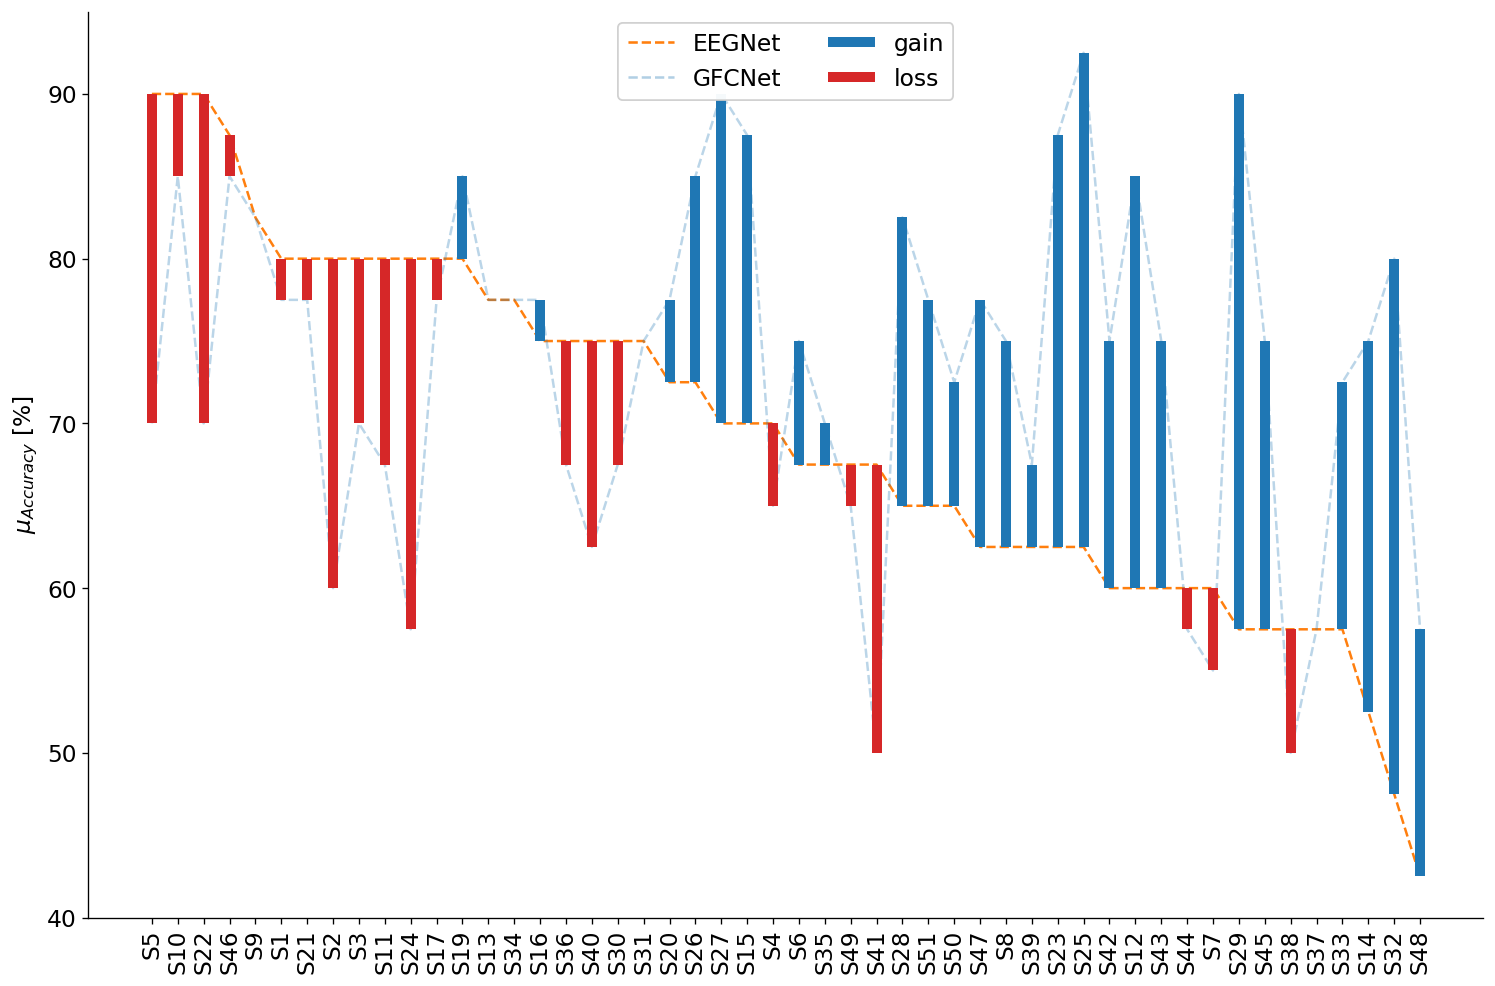

In [22]:
import tikzplotlib
import matplotlib.pyplot as plt
from gcpds.visualizations.accuracy import agco

plt.rcParams.update({'font.size': 14})

ticks = ticks = np.asarray(['S' + str(sbj) for sbj in subjects])
plt.figure(figsize=(15, 10), dpi = 120)
ax1 = plt.subplot()
agco( np.round(raw_eegnet[:, 0]*100, 1),  np.round(my_GFC_scores[:, 0]*100, 1), ticks, ['EEGNet', 'GFCNet'], gain_labels=['gain','loss'],
     gain_c='C0', loss_c='C3',
     ylabel = r'$\mu_{Accuracy}$ [%]', xlabel = '', ax = ax1, fig = plt.gcf())

plt.subplots_adjust(hspace=0.5)
plt.savefig('KCSGFCNetvEEGNet' + ".pdf", format="pdf")